# Install Libraries

In [ ]:
%pip install datasets
%pip install -q git+https://github.com/huggingface/transformers.git

# Import Dependencies

In [ ]:
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import torch
from PIL import Image
import io

# Hough Transform Experiment

We originally saw some potential in a Hough Transform to be able to detect lines and fix some occlusions without even having to detect tree objects, but the detected sidewalk segments seemed to be too irregular to be fit into lines even with extremely lenient rho values. This approach would likely work with a different pre-processing approach (perhaps by compressing the images), but ultimately did not seem worth pursuing for this project as it would only solve occlusions that broke up sidewalks in straight lines, and would require further customization to handle curved sidewalks and intersections. We do, however, believe there is further potential in this more traditional approach.

# Load in and Prepare Dataset

In [ ]:
sidewalk_test = load_dataset("back2classroom/sidewalks", split='val', streaming=True)

In [ ]:
test_images = []
test_labels = []

# Loop through the streamed dataset and collect images and masks
for sample in sidewalk_test:
    test_images.append(sample['tif'])
    test_labels.append(sample['label_tif'])

# Decode a JPEG byte string to a NumPy array
def decode_jpeg_to_array(jpeg_bytes):
    with io.BytesIO(jpeg_bytes) as byte_stream:
        image = Image.open(byte_stream)
        return np.array(image)

valid_indices = []
false_counter = 0

for i, mask_bytes in enumerate(test_labels):
    mask_np = decode_jpeg_to_array(mask_bytes)
    # Check if any pixel in the mask is not zero
    if np.any(mask_np != 0):
        valid_indices.append(i)
    else:
        false_counter += 1

print("Empty masks: ", false_counter)


filtered_images = [test_images[i] for i in valid_indices]
filtered_masks = [test_labels[i] for i in valid_indices]

Empty masks:  9917


In [ ]:
# Convert byte arrays to numpy arrays
def convert_to_numpy(byte_data):
    with io.BytesIO(byte_data) as byte_stream:
        image = Image.open(byte_stream)
        image_np = np.array(image)
        return image_np

def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox


dataset_dict = {
    "image": filtered_images,  # Directly use the byte data
    "label": filtered_masks,   # Directly use the byte data
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

# Sanity Check to Make Sure Data Loaded Properly

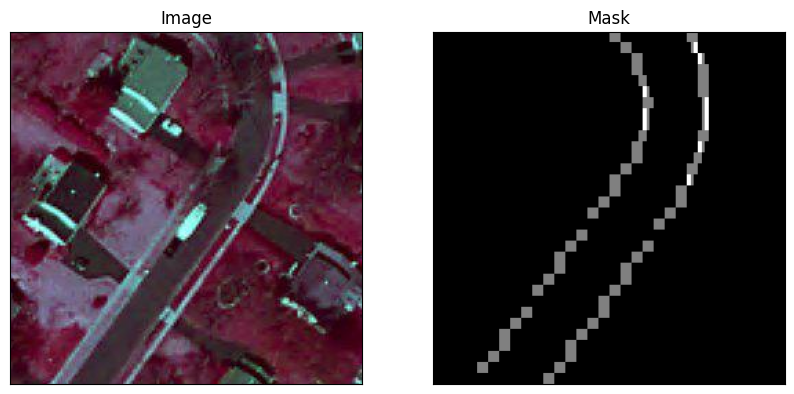

In [ ]:

img_num = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0]-1)

image_np = dataset[img_num]["image"]
mask_np = dataset[img_num]["label"]

image_np = convert_to_numpy(image_np)
mask_np = convert_to_numpy(mask_np)

example_image = Image.fromarray(image_np)
example_mask = Image.fromarray(mask_np)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

# Load Trained Model

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor

# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

In [ ]:
train_model_path = "/content/drive/MyDrive/Colab Notebooks/model_checkpoint_trained_on_train.pth"

# Create an instance of the model architecture with the loaded configuration
train_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
train_model.load_state_dict(torch.load(train_model_path))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
train_model.to(device)
print(device)

cuda


# Define Hough Function

In [ ]:
def visualize_hough_example(dataset, test_model, processor, device):
    """
    Visualizes an example from the dataset along with its predicted segmentation mask and Hough transform results.

    Args:
        dataset (Dataset): A Hugging Face Dataset containing images and labels.
        test_model (torch.nn.Module): The segmentation model to be used for inference.
        processor: The pre-processing function for the model input.
        device: The device (CPU or GPU) to perform inference on.
    """
    from google.colab.patches import cv2_imshow
    import cv2
    # Let's take a random training example
    idx = random.randint(0, convert_to_numpy(filtered_images[0]).shape[0] - 1)

    # Load image
    test_image = Image.fromarray(convert_to_numpy(dataset[idx]["image"]))

    # Get box prompt based on ground truth segmentation map
    ground_truth_mask = convert_to_numpy(dataset[idx]["label"])
    prompt = get_bounding_box(ground_truth_mask)

    # Prepare image + box prompt for the model
    inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

    # Move the input tensor to the GPU if it's not already there
    inputs = {k: v.to(device) for k, v in inputs.items()}

    test_model.eval()

    # Forward pass
    with torch.no_grad():
        outputs = test_model(**inputs, multimask_output=False)

    # Apply sigmoid
    medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # Convert soft mask to hard mask
    medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
    medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot the original image on the left
    axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
    axes[0].set_title("Original Image")

    # Plot the original mask image on the left
    axes[1].imshow(np.array(ground_truth_mask), cmap='gray')  # Assuming the first image is grayscale
    axes[1].set_title("Original Mask")

    # Plot the third image on the right
    axes[2].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
    axes[2].set_title("Predicted Mask")

    #Hough Transform
    minLineLength = 2
    maxLineGap = 1000
    # Convert the binary mask to uint8 image
    medsam_gray = medsam_seg.astype(np.uint8) * 255
    medsam_gray = cv2.cvtColor(medsam_gray, cv2.COLOR_GRAY2BGR)
    edges = cv2.Canny(medsam_gray,50,150,apertureSize = 3)
    lines = cv2.HoughLinesP(edges,500,np.pi/360,10,minLineLength,maxLineGap)
    print("Lines detected: ", lines)
    # Create a copy of the original image to draw lines on
    img_with_lines = edges.copy()

    if lines is not None:
      for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img_with_lines, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Plot the hough transform image on the right
    axes[3].imshow(img_with_lines, cmap='gray')
    axes[3].set_title("Hough Results")

    # Hide axis ticks and labels
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])

    # Display the images side by side
    plt.show()

# Hough Experiment Results

As seen below, the results were disappointing. No lines were detected in any of the images. Compressing the images may allow for smoother lines in the edges, but as is the segments produced extremely irregular edges. We also tested other edge detection algorithms, and altogether removed the edge detection preprocessing, but never managed to detect more than a handful of lines. More involved preprocessing would likely yield better results, but this did not seem worth pursuing for this project.

Lines detected:  None


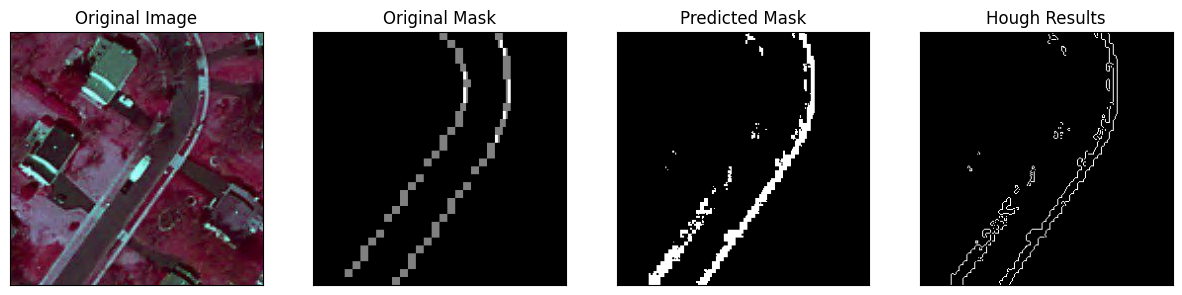

Lines detected:  None


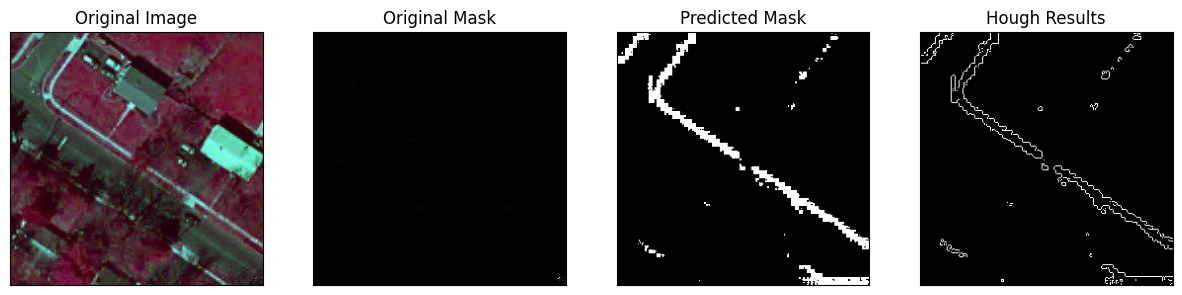

Lines detected:  None


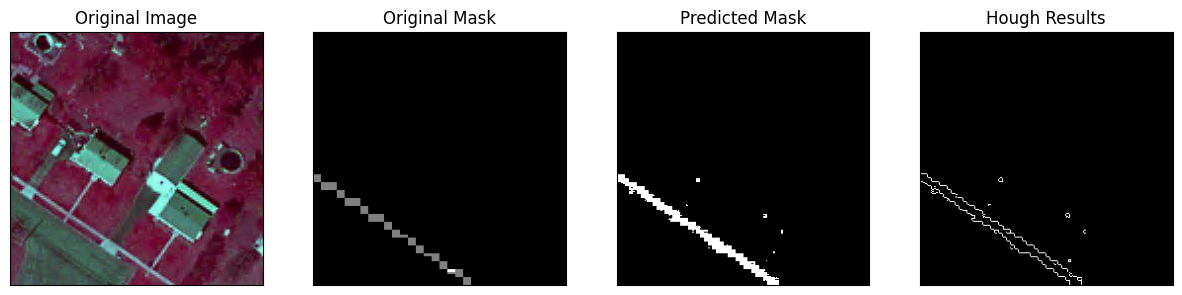

Lines detected:  None


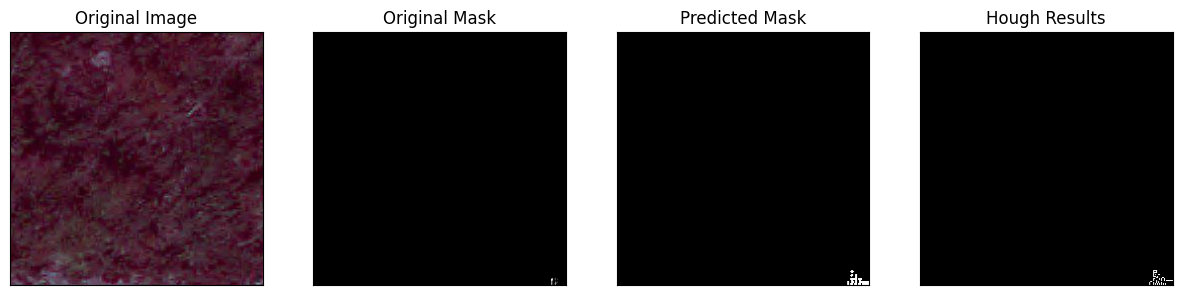

Lines detected:  None


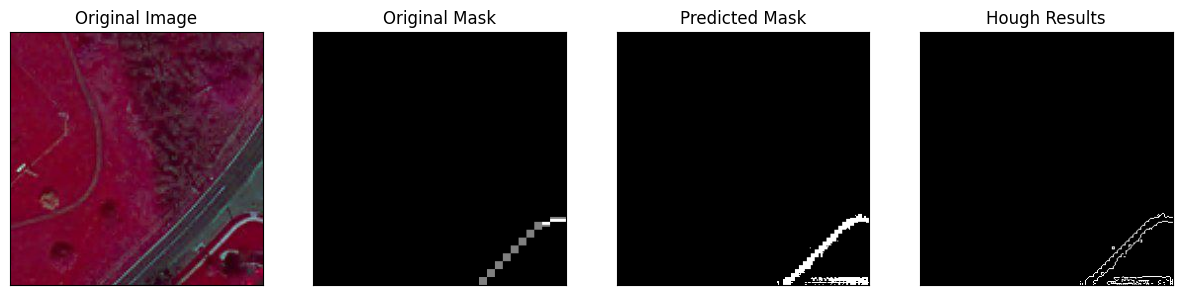

Lines detected:  None


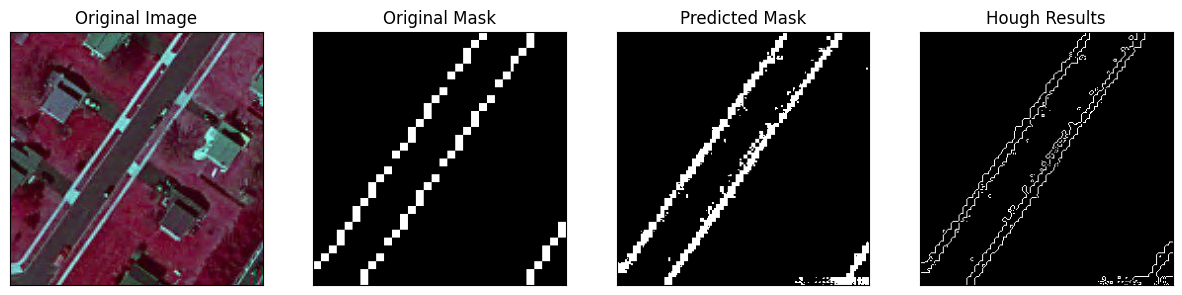

Lines detected:  None


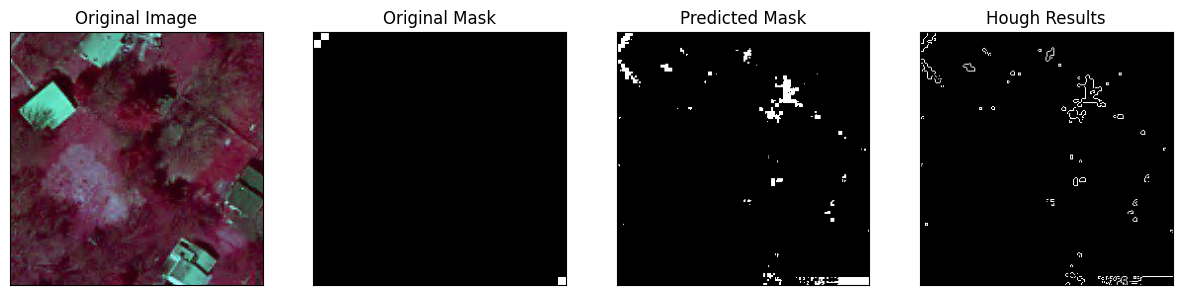

Lines detected:  None


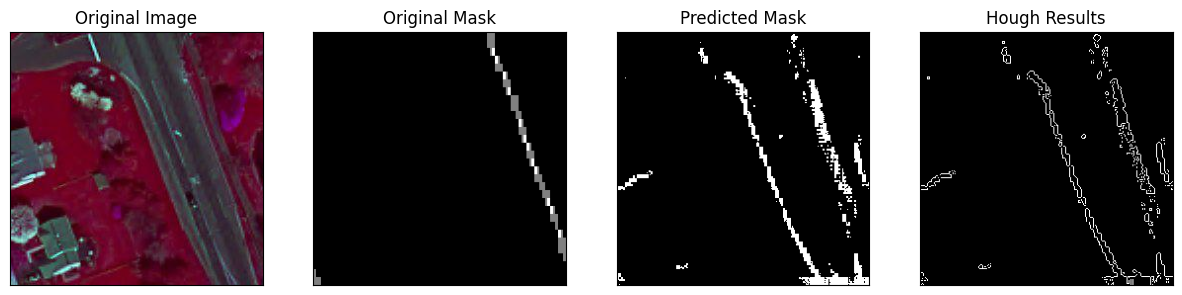

Lines detected:  None


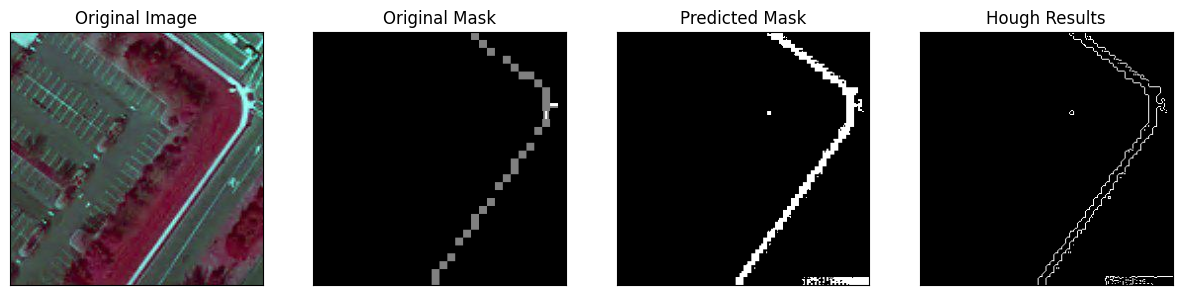

Lines detected:  None


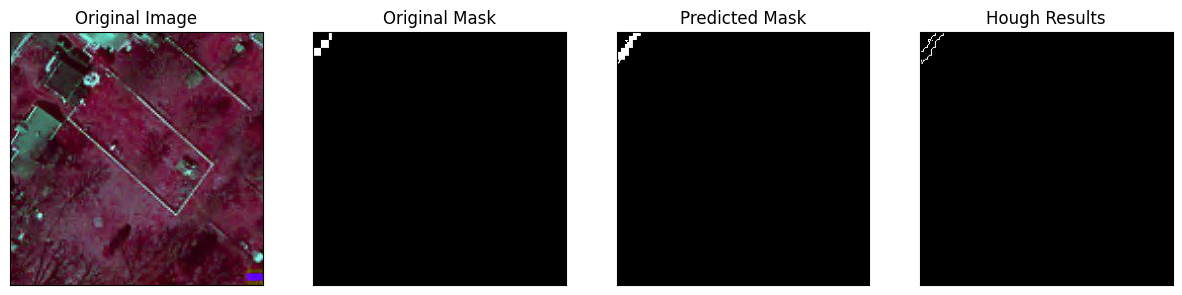

In [ ]:
for i in range(10):
  visualize_hough_example(dataset, train_model, processor, device)